# Final Project: Cats & Dogs

This project is taken from Kaggle: [Cat and Dog](https://www.kaggle.com/tongpython/cat-and-dog)

<img src="images/cat_dog.gif" width="600"/>


## Contributors:
* Peihang Xu
* Ryan Samimi
* Feifan Yu

---
## Project Files
The compressed project zip file should contain the following files and folders:
* Final_project_distinguish_cat_dog.ipynb
* cat-and-dog.zip
* requirements.txt

## Setup environment
If using conda, you can use `requirements.txt` file to setup the new environment (e.g. `final_pr`)

<code>
    $ conda create final_pr --file requirements.txt
    $ conda activate final_pr
</code>

## Prepare dataset
The dataset contains 10,000 pictures of cats and dogs which are compressed into `cat-and-dog.zip` file. Unzip `cat-and-dog.zip` and the dataset is ready to be used.

---
## Imports

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import joblib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from keras.preprocessing import image

from keras.models import Sequential                # creating sequential model of CNN
from keras.layers import Conv2D                    # creating convolution layer
from keras.layers import MaxPooling2D              # creating maxpool layer
from keras.layers import Flatten                   # creating input vector for dense layer
from keras.layers import Dense                     # create dense layer or fully connected layer
from keras.layers import Dropout                   # use to avoid overfitting by droping some params
from keras.layers import BatchNormalization        # for batch normalization
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

train_dir = 'cat-and-dog/training_set'
test_dir = 'cat-and-dog/test_set'
dumps_dir = 'dumps'

Using TensorFlow backend.


# Utility functions

In [2]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.legend()

# Preprocessing Images

## Image Loading function

In [3]:
def load_dataset(path, dim):
    """
    This function is used to load images in training and test folders
    ;param path: path to the given folder
    ;param dim: dimension used to resize the image
    """
    image_names = []
    data_labels = []
    data_images = []
    for folder in os.listdir(path):
        if folder != '.DS_Store':
            for file in os.listdir(os.path.join(path, folder)):
                if file.lower().endswith(".jpg"):
                    image_names.append(os.path.join(path, folder, file))
                    data_labels.append(folder)
                    img = cv2.imread(os.path.join(path, folder, file))
                    if dim is not None:
                        img = cv2.resize(img, dim)
                    data_images.append(img)
    return image_names, data_images, data_labels

## Load images into training and test sets

In [4]:
# Make sure to download the dataset into the same folder as the project's pynb file. (see readme)
img_size = (64, 64)

''' Load trainging set '''
image_tr_names, data_tr_images, data_tr_labels = load_dataset(train_dir, img_size)

''' Load test set '''
image_te_names, data_te_images, data_te_labels = load_dataset(test_dir, img_size)

## Verify a sample image

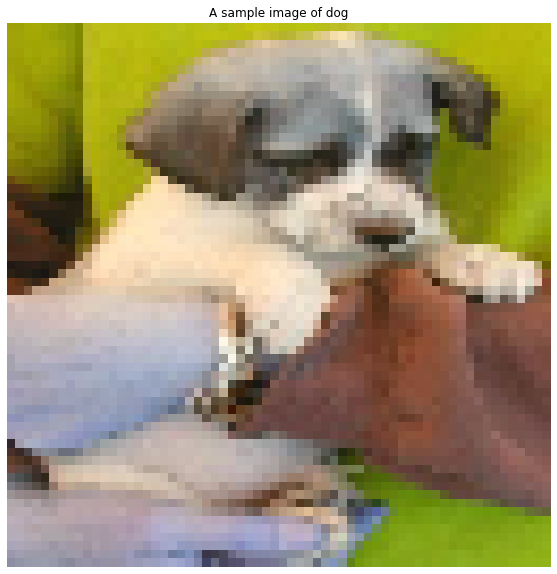

In [5]:
fig = plt.figure(figsize=(10,10))
plt.imshow(data_tr_images[10])
plt.title('A sample image of dog')
plt.axis('off')
plt.show()

In [11]:
# checks

data_X_tr_va = np.array(data_tr_images)
data_y_tr_va = np.array(data_tr_labels)
print(f"Number of images for cats in train set {np.count_nonzero(data_y_tr_va=='cats')}")
print(f"Number of images for dogs in train set {np.count_nonzero(data_y_tr_va=='dogs')}")

data_X_te = np.array(data_te_images)
data_y_te = np.array(data_te_labels)
print(f"Number of images for cats in test set {np.count_nonzero(data_y_te=='cats')}")
print(f"Number of images for dogs in test set {np.count_nonzero(data_y_te=='dogs')}")

Number of images for cats in train set 4000
Number of images for dogs in train set 4000
Number of images for cats in test set 1000
Number of images for dogs in test set 1000


## Processing Labels and Train-valid Splitting

In [12]:
# cats=0 dogs=1

data_y_tr_va[data_y_tr_va=='dogs'] = 1
data_y_tr_va[data_y_tr_va=='cats'] = 0
data_y_te[data_y_te=='dogs'] = 1
data_y_te[data_y_te=='cats'] = 0

# array([1, 2, 2]) = [int(numeric_string) for numeric_string in data_y_te]

In [13]:
data_y_te = data_y_te.astype(int)
data_y_tr_va = data_y_tr_va.astype(int)

In [14]:
strat_split = StratifiedShuffleSplit(test_size=0.15, random_state=42)
train_idx = None
valid_idx = None

for tr_idx, va_idx in strat_split.split(data_X_tr_va,data_y_tr_va):
    valid_idx = va_idx
    train_idx = tr_idx

data_X_tr = data_X_tr_va[train_idx]
data_y_tr = data_y_tr_va[train_idx]
data_X_va = data_X_tr_va[valid_idx]
data_y_va = data_y_tr_va[valid_idx]

print("X_train shape",data_X_tr.shape)
print("X_val shape",data_X_va.shape)
print("y_train shape",data_y_tr.shape)
print("y_val shape",data_y_va.shape)
print("train set dog images",np.count_nonzero(data_y_tr==0))

X_train shape (6800, 64, 64, 3)
X_val shape (1200, 64, 64, 3)
y_train shape (6800,)
y_val shape (1200,)
train set dog images 3400


In [15]:
data_X_tr = data_X_tr/255.
data_X_va = data_X_va/255.
data_X_te = data_X_te/255.

---
# Build CNN model, and train on numpy arrays

## Build Model

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

classifier = Sequential([
        Conv2D(15, (3, 3), input_shape = (img_size[0],img_size[1], 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
        Conv2D(15, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
        Flatten(),
        BatchNormalization(),
        Dense(output_dim= 100, activation="elu",kernel_initializer="he_normal"),
        BatchNormalization(),
        Dense(output_dim= 1, activation='sigmoid',kernel_initializer="glorot_normal")
])

classifier.summary()


/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="elu", kernel_initializer="he_normal", units=100)`
  
/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", kernel_initializer="glorot_normal", units=1)`
  app.launch_new_instance()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 15)        420       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 15)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2940)             

In [17]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

#Although I have defined some learning rate schedulers, I did not use in the model, since I am using Adam optimizer

In [18]:
optimizer = tf.keras.optimizers.Adam()
classifier.compile(optimizer= optimizer, loss= 'binary_crossentropy', metrics= ['accuracy'])
# classifier.summary()

In [19]:
patience = 25
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,restore_best_weights=True)

# Model Training

In [20]:
history = classifier.fit(data_X_tr,data_y_tr,epochs=100,validation_data=(data_X_va, data_y_va),
                    batch_size=1000,callbacks=[early_stopping_cb])
joblib.dump(history, os.path.join(dumps_dir, 'history_model_1.pkl'))

# alternatively, load the pickle file
# history = joblib.load(os.path.join('dumps', 'history_model_1.pkl'))

Train on 6800 samples, validate on 1200 samples
Epoch 1/100
6800/6800 [==============================] - 9s 1ms/step - loss: 0.8369 - accuracy: 0.5374 - val_loss: 0.8228 - val_accuracy: 0.5325
Epoch 2/100
6800/6800 [==============================] - 8s 1ms/step - loss: 0.7603 - accuracy: 0.5944 - val_loss: 1.3567 - val_accuracy: 0.5000
Epoch 3/100
6800/6800 [==============================] - 9s 1ms/step - loss: 0.7314 - accuracy: 0.5997 - val_loss: 1.3139 - val_accuracy: 0.5000
Epoch 4/100
6800/6800 [==============================] - 9s 1ms/step - loss: 0.6919 - accuracy: 0.6234 - val_loss: 1.0279 - val_accuracy: 0.5100
Epoch 5/100
6800/6800 [==============================] - 9s 1ms/step - loss: 0.6721 - accuracy: 0.6363 - val_loss: 0.8634 - val_accuracy: 0.5433
Epoch 6/100
6800/6800 [==============================] - 9s 1ms/step - loss: 0.6467 - accuracy: 0.6424 - val_loss: 0.6688 - val_accuracy: 0.6167
Epoch 7/100
6800/6800 [==============================] - 8s 1ms/step - loss: 0.612

/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


['dumps/history_model_1.pkl']

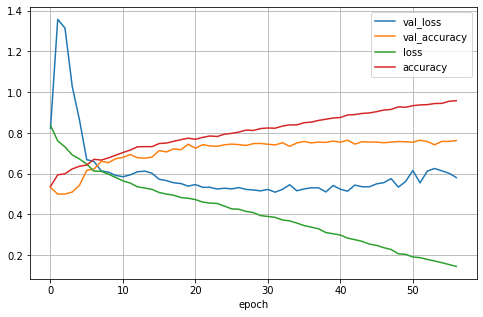

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [22]:
classifier.save(os.path.join(dumps_dir, 'cat-dog-model-1.h5'))

/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


## Model Performance for Test Set

In [27]:
classifier = keras.models.load_model(os.path.join(dumps_dir, 'cat-dog-model-1.h5'))

In [28]:
y_pred_proba_test = classifier.predict(data_X_te)
y_pred_test = y_pred_proba_test>=0.5

print("ROC curve AUC:", roc_auc_score(data_y_te,y_pred_proba_test))
print('Accuracy for test set:', accuracy_score(data_y_te,y_pred_test))

ROC curve AUC: 0.8230790000000001
Accuracy for test set: 0.7465


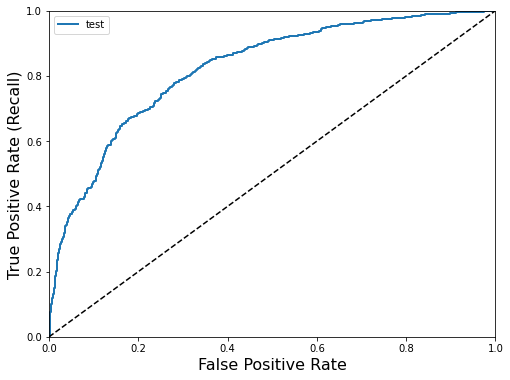

In [29]:
fpr_test, tpr_test, thresholds_test = roc_curve(data_y_te, y_pred_proba_test[:,0])

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_test, tpr_test, 'test')
plt.show()

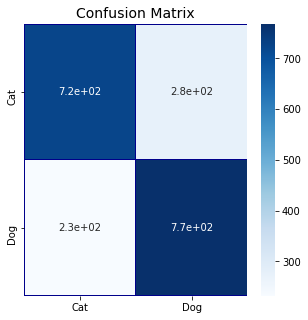

In [30]:
cm = confusion_matrix(data_y_te, y_pred_test)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Summary

 - This model is very fundamental. We just build the layers for a sequential model, compile and fit the model on the preprocessed images done by ourselves.
 - To have faster training time, we reszie/compress the size of the images to 64x64x3, which could lose a lot of information and make the training harder.
 - This is really a starting model, the next thing we want to try is using image generator from keras and implement data augmentation

---
# Using keras image generator for data augmentation

## Image Generators 

In [6]:
train_gen = ImageDataGenerator(rescale=1.0/255.0,
                              shear_range=0.2,
                              zoom_range=0.2,
                              rotation_range=45, #Int. degree range for random rotations.
                              width_shift_range=0.2, #fraction of total width
                              height_shift_range=0.2,#fraction of total height
                              horizontal_flip=True) #enable possible flip of images horizontally

test_gen = ImageDataGenerator(rescale = 1./255.0) #just rescale for test set, no more augmentation

imgsize = 150

X_train = train_gen.flow_from_directory(train_dir,
                                          target_size = (imgsize,imgsize),
                                          batch_size = 32,
                                          class_mode = 'binary') # For train data, select directory, sizes and import
X_test = test_gen.flow_from_directory(test_dir,
                                         target_size = (imgsize,imgsize),
                                         batch_size = 32,
                                         class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Test the idea of the generator

Found 8000 images belonging to 2 classes.


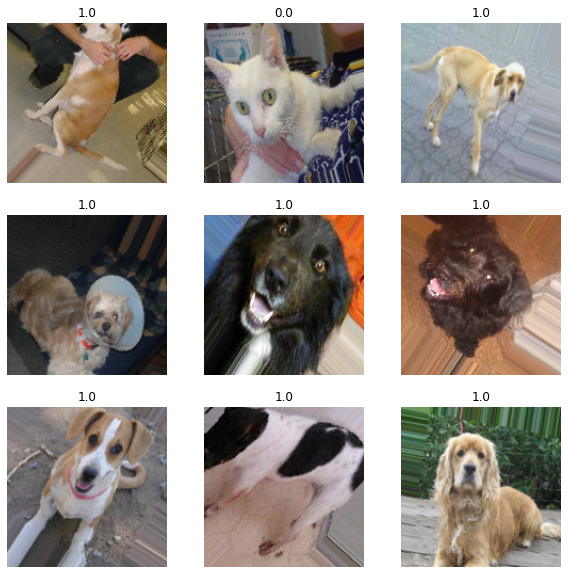

In [7]:
for X_batch,y_batch in train_gen.flow_from_directory(train_dir,
                                          target_size = (imgsize,imgsize),
                                          batch_size = 9,
                                          class_mode = 'binary'): # For train data, select directory, sizes and import
    # create a grid of 3x3 images
    plt.figure(figsize=(10,10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(imgsize, imgsize,3), cmap=plt.get_cmap('gray'))
        plt.title(str(y_batch[i]))
        plt.axis('off')
    # show the plot
    plt.show()
    break

## Build the Model 

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

classifier = Sequential([
        Conv2D(32, (3, 3), input_shape = (imgsize,imgsize,3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        BatchNormalization(),
        Dense(output_dim= 512, activation="elu",kernel_initializer="he_normal"),
        BatchNormalization(),
        Dense(output_dim= 1, activation='sigmoid',kernel_initializer="glorot_normal")
])

classifier.summary()


/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="elu", kernel_initializer="he_normal", units=512)`
  app.launch_new_instance()
/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", kernel_initializer="glorot_normal", units=1)`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [9]:
optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(optimizer= 'Adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [10]:
patience = 30
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=patience,restore_best_weights=True)

# Model Training

In [11]:
history = classifier.fit_generator(X_train, epochs=150, validation_data=X_test,callbacks =[early_stopping_cb])
joblib.dump(history, os.path.join(dumps_dir, 'history_model_2.pkl'))

# alternatively, load the pickle file
# history = joblib.load(os.path.join('dumps', 'history_model_2.pkl'))

Epoch 1/150
250/250 [==============================] - 164s 656ms/step - loss: 0.7809 - accuracy: 0.6026 - val_loss: 1.6007 - val_accuracy: 0.5030
Epoch 2/150
250/250 [==============================] - 150s 602ms/step - loss: 0.6518 - accuracy: 0.6298 - val_loss: 1.1583 - val_accuracy: 0.5935
Epoch 3/150
250/250 [==============================] - 155s 622ms/step - loss: 0.6316 - accuracy: 0.6485 - val_loss: 0.7317 - val_accuracy: 0.5410
Epoch 4/150
250/250 [==============================] - 155s 618ms/step - loss: 0.6146 - accuracy: 0.6649 - val_loss: 0.5919 - val_accuracy: 0.6305
Epoch 5/150
250/250 [==============================] - 159s 637ms/step - loss: 0.5996 - accuracy: 0.6736 - val_loss: 0.4756 - val_accuracy: 0.7255
Epoch 6/150
250/250 [==============================] - 157s 626ms/step - loss: 0.5842 - accuracy: 0.6870 - val_loss: 0.7895 - val_accuracy: 0.6365
Epoch 7/150
250/250 [==============================] - 155s 620ms/step - loss: 0.5686 - accuracy: 0.7014 - val_loss: 0

['dumps/history_model_2.pkl']

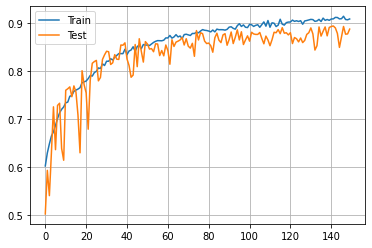

In [12]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
classifier.save(os.path.join(dumps_dir, 'cats-dogs-model-2.h5'))

## Model Performance for Test Set

In [26]:
classifier = keras.models.load_model(os.path.join(dumps_dir, 'cats-dogs-model-2.h5'))

In [27]:
# prepare test data for img size 150x150
imgsize = 150
img_size = (imgsize,imgsize)
image_te_names, data_te_images, data_te_labels = load_dataset(test_dir, img_size)
data_X_te = np.array(data_te_images)
data_y_te = np.array(data_te_labels)
data_y_te[data_y_te=='dogs'] = 1
data_y_te[data_y_te=='cats'] = 0
data_y_te = data_y_te.astype(int)
data_X_te = np.array(data_te_images)/255.
data_X_te.shape

(2000, 150, 150, 3)

In [28]:
y_pred_proba_test = classifier.predict(data_X_te)
y_pred_test = y_pred_proba_test>=0.5

print("ROC curve AUC:", roc_auc_score(data_y_te,y_pred_proba_test))
print("Accuracy for test set:", accuracy_score(data_y_te,y_pred_test))

ROC curve AUC: 0.9155979999999999
Accuracy for test set: 0.84


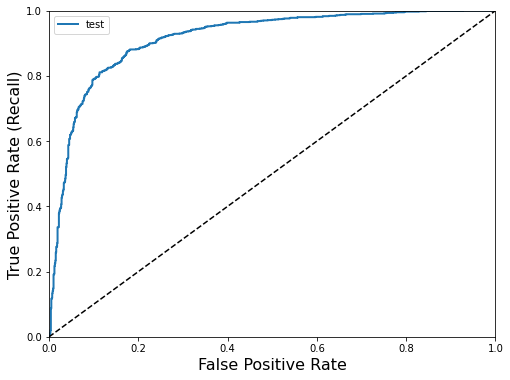

In [29]:
fpr_test, tpr_test, thresholds_test = roc_curve(data_y_te, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_test, tpr_test, 'test')
plt.show()

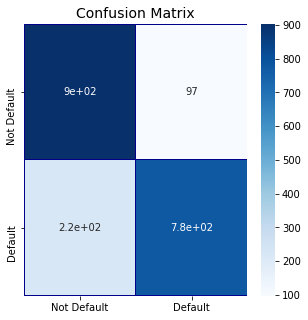

In [30]:
cm = confusion_matrix(data_y_te, y_pred_proba_test>0.5)
# cm = confusion_matrix(df_y_train, RF_clf_proba[:,1]>=0.5)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Summary

- This model performs much better with data augmentation

---
# Transfer Learning

## Build Model

In [31]:
from keras.applications import mobilenet
from keras.applications.mobilenet import preprocess_input
from keras.models import Sequential, Model, Input

In [32]:
imgsize = 224

X_train_trans = train_gen.flow_from_directory(train_dir,
                                          target_size = (imgsize,imgsize),
                                          batch_size = 32,
                                          class_mode = 'binary') # For train data, select directory, sizes and import
X_test_trans = test_gen.flow_from_directory(test_dir,
                                         target_size = (imgsize,imgsize),
                                         batch_size = 32,
                                         class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [33]:
mobilenet_model = mobilenet.MobileNet(input_shape = (imgsize, imgsize, 3), weights='imagenet', include_top=False)

In [34]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [35]:
inputs = Input(shape=(imgsize, imgsize, 3))
x = mobilenet_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x) # to avoid overfitting
x = Dense(512, activation='relu')(x) # dense layer 2

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.layers[1].trainable = True

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513 

In [36]:
# Try to make only the whole block 13 trainable for MobileNet

mbn_layers = np.array(model.layers[1].layers).shape[0]
for index,l in enumerate(model.layers[1].layers):
     if index <= mbn_layers-6:
            l.trainable=False
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513 

In [37]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss= 'binary_crossentropy', metrics= ['accuracy'])

history = model.fit_generator(X_train_trans, epochs= 3, 
                              validation_data = X_test_trans)
joblib.dump(history, os.path.join(dumps_dir, 'history_model_3.pkl'))

# alternatively, load the pickle file
# history = joblib.load(os.path.join('dumps', 'history_model_3.pkl'))

Epoch 1/3
250/250 [==============================] - 427s 2s/step - loss: 0.1719 - accuracy: 0.9345 - val_loss: 0.0066 - val_accuracy: 0.9805
Epoch 2/3
250/250 [==============================] - 426s 2s/step - loss: 0.1037 - accuracy: 0.9603 - val_loss: 0.0140 - val_accuracy: 0.9860
Epoch 3/3
250/250 [==============================] - 432s 2s/step - loss: 0.0975 - accuracy: 0.9628 - val_loss: 0.0283 - val_accuracy: 0.9660


/Users/peihangxu/opt/anaconda3/envs/TF/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


['dumps/history_model_3.pkl']

In [38]:
model.save(os.path.join(dumps_dir, 'cats-and-dogs-transfer-model.h5'))

## Model Performance for Test Set

In [39]:
model = tf.keras.models.load_model(os.path.join(dumps_dir, 'cats-and-dogs-transfer-model.h5'))

In [40]:
# prepare test data for img size 224x224
imgsize = 224
img_size = (imgsize,imgsize)
image_te_names, data_te_images, data_te_labels = load_dataset(test_dir, img_size)
data_X_te = np.array(data_te_images)
data_y_te = np.array(data_te_labels)
data_y_te[data_y_te=='dogs'] = 1
data_y_te[data_y_te=='cats'] = 0
data_y_te = data_y_te.astype(int)
data_X_te = np.array(data_te_images)/255.
data_X_te.shape

(2000, 224, 224, 3)

In [41]:
y_pred_proba_test = model.predict(data_X_te)
y_pred_test = y_pred_proba_test>=0.5

print("ROC curve AUC:", roc_auc_score(data_y_te,y_pred_proba_test))
print("Accuracy for test set:", accuracy_score(data_y_te,y_pred_test))

ROC curve AUC: 0.998166
Accuracy for test set: 0.9645


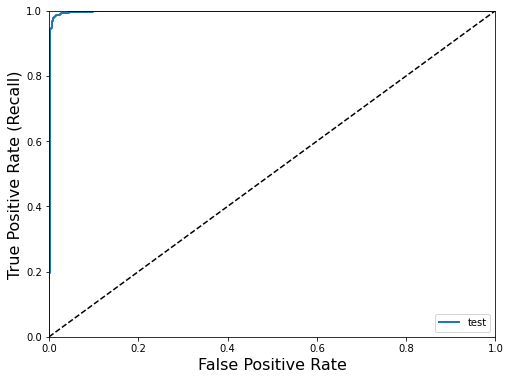

In [42]:
fpr_test, tpr_test, thresholds_test = roc_curve(data_y_te, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_test, tpr_test, 'test')
plt.show()

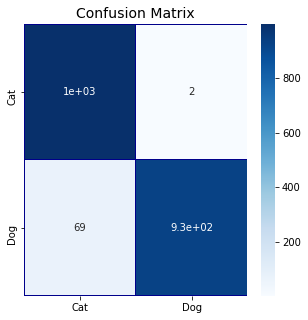

In [43]:
cm = confusion_matrix(data_y_te, y_pred_proba_test>0.5)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Summary

- Boom! Transferlearning is amazing!
- Actually we do not need to train many epochs to get good results!
- It definitely takes longer for each epoch since there are more training parameters!